In [1]:
import numpy as np
import pandas as pd
import json
import os
os.environ["OMP_NUM_THREADS"] = '1'


from langchain.prompts import PromptTemplate
from llama_index.embeddings.langchain import LangchainEmbedding
from langchain.embeddings import HuggingFaceEmbeddings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from umap import umap_ as UMAP
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
import openai

openai_api_key = os.getenv("OPENAI_API_KEY")

openai.api_key = openai_api_key
client = openai.Client()

chat_model_name = 'gpt-4o-mini'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'

s_root = r'C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/'
s_db_json = 'Data/survey_results_with_topics.json'

s_db_embed_json = 'Data/review_db_embed.json'
s_db_table_json = 'Data/review_db_table.json'
s_db_table_xlsx = 'Data/review_db_table.xlsx'
s_db_table_pca_json = 'Data/review_db_table_pca.json'
s_db_table_pca_xlsx = 'Data/review_db_table_pca.xlsx'
s_kmeans_centers = 'Data/kmeans_centers.json'
b_override = False

In [26]:

prompt_template_translation = PromptTemplate.from_template(
'''Please tell if the following game review sections are written in English. Respond with "Yes." or "No."
Furthermore, please translate each section into English if it is not. The sections are separated by labels "REASON" and "WISH".

[h0]==================================================================[\h0]
REASON: "兄弟们，我把星空退款的钱拿来买这个了，我做的对吗"
WISH: "加动态模糊和垂直同步选项"

IS ENGLISH:

No.

TRANSLATION:

REASON: "Brothers, I used the refund money from the stars to buy this. Did I do the right thing?"
WISH: "Add dynamic blur and vertical sync options."


[h0]==================================================================[\h0]
REASON: "My first D&D experience and I'm enjoying it a lot."
WISH: "I would like more guidance in the game."

IS ENGLISH: 

Yes.


[h0]==================================================================[\h0]
REASON: "{reason}"
WISH: "{wish}"

IS ENGLISH: 
'''
)

prompt_template_topic = PromptTemplate.from_template(
'''Please list the most important topics and their respective original context in the review of a game in a json format with "Topic", "Category", "Context" arguments.  No more than 10 topics.
Topics should be game features.  A feature in the game should be a noun rather than a verb or an adjective.
Each topic should be categorized as a "fact" or a "request".
Respond in JSON format.

[h0]==================================================================[\h0]
REVIEW: 

"The weapon durability in this game is frustrating; my sword breaks after just a few swings. The combat itself is fun, but I wish the durability lasted longer. Also, the audio effects are very immersive during battles."

TOPICS:

[
    {{
        "Topic": "Weapon Durability",
        "Category": "request",
        "Context": "My sword breaks after just a few swings. I wish the durability lasted longer."
    }},
    {{
        "Topic": "Combat and Fighting",
        "Category": "fact",
        "Context": "The combat itself is fun."
    }},
    {{
        "Topic": "Audio",
        "Category": "fact",
        "Context": "The audio effects are very immersive during battles."
    }}
]

[h0]==================================================================[\h0]
REVIEW: 

"Playing during the night adds a thrilling layer to the game. The lack of a proper save feature makes it hard to enjoy it though. Also, there are way too many random encounters that make progress difficult."

TOPICS:

[
    {{
        "Topic": "Night",
        "Category": "fact",
        "Context": "Playing during the night adds a thrilling layer to the game."
    }},
    {{
        "Topic": "Save Feature",
        "Category": "request",
        "Context": "The lack of a proper save feature makes it hard to enjoy fully."
    }},
    {{
        "Topic": "Randomness",
        "Category": "request",
        "Context": "There are way too many random encounters that make progress difficult."
    }}
]

[h0]==================================================================[\h0]
REVIEW: 

"{review}"

TOPICS:

'''
)

prompt_template_topic_view = PromptTemplate.from_template(
'''What's the sentiment of the review with regard to the topic?
Always answer with 'Positive' or 'Negative' or 'Inconclusive'.

REVIEW: My first D&D experience and I'm enjoying it a lot.
TOPIC: D&D
SENTIMENT: Positive 

REVIEW: This game lacks a proper ending or epilog
TOPIC: epilogue
SENTIMENT: Negative

REVIEW: Posted: August 8
TOPIC: release date
SENTIMENT: Inconclusive 

REVIEW: {review}
TOPIC: {topic}
SENTIMENT: '''
)

In [4]:
# Read in the JSON file with survey results 

with open(s_root + 'Data/survey_results_clean.json', 'r') as f:
    db = json.load(f)

## Translate reviews

In [5]:
import json
from lingua import Language, LanguageDetectorBuilder



# Load JSON data from file
input_file_path = 'Data/survey_results_clean.json'  # Adjust the path if needed
output_file_path = 'Data/survey_results_trans.json'  # New JSON with language and translations

# Initialize the language detector
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.SPANISH, Language.CHINESE, Language.GERMAN, Language.FRENCH
).build()

# Load JSON data
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Process each entry
for entry in data:
    reason_text = entry.get("Please tell us why you chose the rating above:", "")
    wish_text = entry.get("If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?", "")

    # Detect language of both fields using Lingua
    detected_language_reason = detector.detect_language_of(reason_text).name.lower() if detector.detect_language_of(reason_text) else "unknown"
    detected_language_wish = detector.detect_language_of(wish_text).name.lower() if detector.detect_language_of(wish_text) else "unknown"

    # Determine overall language
    detected_language = detected_language_reason if detected_language_reason == detected_language_wish else "mixed"
    entry["language"] = detected_language

    # Only proceed to translation if either field is not in English
    if detected_language != "english":
        # Format the prompt for translation with both texts
        prompt_translation = prompt_template_translation.format(reason=reason_text, wish=wish_text)

        # Make the OpenAI API call to translate the review
        response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant expertised in game review analysis."},
                {"role": "user", "content": prompt_translation},
            ],
            max_tokens=1024,
        )

        # Extract the translation response
        translation_response = response.choices[0].message.content

        # Parse the response to extract translations for REASON and WISH
        if "REASON:" in translation_response and "WISH:" in translation_response:
            reason_translation = translation_response.split("REASON:")[1].split("WISH:")[0].strip()
            wish_translation = translation_response.split("WISH:")[1].strip()

            # Overwrite the original fields with translations
            entry["Please tell us why you chose the rating above:"] = reason_translation
            entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"] = wish_translation
        else:
            print(f"Translation not available for entry: {entry}")

# Save the modified data with translations
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

print(f"Translated data saved to {output_file_path}")


Translated data saved to Data/survey_results_trans.json


## Topic Extraction

In [15]:
with open(s_root + 'Data/survey_results_trans.json', 'r') as f:
    db = json.load(f)

entry = db[0]

# Extract important information from the 2nd and 3rd keys
review_text = entry["Please tell us why you chose the rating above:"]
additional_feedback = entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"]

# Combine both into a single review input for the prompt
combined_review = f"{review_text} {additional_feedback}"

# Format the prompt for the LLM
prompt_topic = prompt_template_topic.format(review=combined_review)

# Make the OpenAI API call
response = client.chat.completions.create(
    model=chat_model_name,
    messages=[
        {"role": "system", "content": "You are a helpful assistant expertised in game review analysis. Respond in JSON format."},
        {"role": "user", "content": prompt_topic},
    ],
    max_tokens=1024,
    response_format={
    "type": "json_object"
  }
)

# Print the response content
print(response.choices[0].message.content)

2024-11-12 15:35:50,209 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{
    "topics": [
        {
            "Topic": "Survival Mechanics",
            "Category": "fact",
            "Context": "The game is inherently difficult due to survival and concerns about resources."
        },
        {
            "Topic": "Gameplay Experience",
            "Category": "fact",
            "Context": "I really liked it and I am anxiously waiting for the finished game."
        },
        {
            "Topic": "Expectations",
            "Category": "fact",
            "Context": "I have high expectations waiting for the finished game, like what the demo left me."
        },
        {
            "Topic": "Game Difficulty",
            "Category": "fact",
            "Context": "The game is inherently difficult, which makes it interesting."
        },
        {
            "Topic": "Resource Management",
            "Category": "fact",
            "Context": "Concerns about resources make the game interesting since other zombie games do not have this."
        

## Sentiment Analysis

In [16]:
topic_response = response.choices[0].message.content
topics = json.loads(topic_response)

In [21]:
topics

{'topics': [{'Topic': 'Survival Mechanics',
   'Category': 'fact',
   'Context': 'The game is inherently difficult due to survival and concerns about resources.'},
  {'Topic': 'Gameplay Experience',
   'Category': 'fact',
   'Context': 'I really liked it and I am anxiously waiting for the finished game.'},
  {'Topic': 'Expectations',
   'Category': 'fact',
   'Context': 'I have high expectations waiting for the finished game, like what the demo left me.'},
  {'Topic': 'Game Difficulty',
   'Category': 'fact',
   'Context': 'The game is inherently difficult, which makes it interesting.'},
  {'Topic': 'Resource Management',
   'Category': 'fact',
   'Context': 'Concerns about resources make the game interesting since other zombie games do not have this.'}]}

In [27]:
# Access the list of topics within the 'topics' dictionary
for topic in topics['topics']:
    topic_text = topic["Topic"]
    topic_category = topic["Category"]
    topic_context = topic["Context"]

    # Append the topic information to the "topics" list in entry
    if "topics" not in entry:
        entry["topics"] = []

    entry["topics"].append({
        "topic": topic_text,
        "category": topic_category,
        "sentence": topic_context
    })

    # Print for confirmation
    print(f"Topic: {topic_text}\nCategory: {topic_category}\nContext: {topic_context}\n")


Topic: Survival Mechanics
Category: fact
Context: The game is inherently difficult due to survival and concerns about resources.

Topic: Gameplay Experience
Category: fact
Context: I really liked it and I am anxiously waiting for the finished game.

Topic: Expectations
Category: fact
Context: I have high expectations waiting for the finished game, like what the demo left me.

Topic: Game Difficulty
Category: fact
Context: The game is inherently difficult, which makes it interesting.

Topic: Resource Management
Category: fact
Context: Concerns about resources make the game interesting since other zombie games do not have this.



In [28]:
# Iterate over each topic in the nested structure
for topic in topics['topics']:
    topic_text = topic["Topic"]
    topic_context = topic["Context"]
    
    # Format the prompt for sentiment analysis
    prompt_sentiment = prompt_template_topic_view.format(review=topic_context, topic=topic_text)
    
    # Call the API for sentiment analysis
    sentiment_response = client.chat.completions.create(
        model=chat_model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant expertised in sentiment analysis."},
            {"role": "user", "content": prompt_sentiment},
        ],
        max_tokens=1024,
    )
    
    # Extract the sentiment from the response
    sentiment = sentiment_response.choices[0].message.content.strip()
    
    # Ensure 'topics' key is initialized in the entry
    if "topics" not in entry:
        entry["topics"] = []

    # Append the topic information with sentiment to the "topics" list
    entry["topics"].append({
        "topic": topic_text,
        "context": topic_context,
        "category": topic["Category"],  # Add category from original data
        "sentiment": sentiment
    })

    # Print for confirmation
    print(f"Topic: {topic_text}\nContext: {topic_context}\nCategory: {topic['Category']}\nSentiment: {sentiment}\n")


2024-11-12 15:59:46,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Survival Mechanics
Context: The game is inherently difficult due to survival and concerns about resources.
Category: fact
Sentiment: Negative



2024-11-12 15:59:46,935 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Gameplay Experience
Context: I really liked it and I am anxiously waiting for the finished game.
Category: fact
Sentiment: Positive



2024-11-12 15:59:47,286 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Expectations
Context: I have high expectations waiting for the finished game, like what the demo left me.
Category: fact
Sentiment: Positive



2024-11-12 15:59:47,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Game Difficulty
Context: The game is inherently difficult, which makes it interesting.
Category: fact
Sentiment: Positive



2024-11-12 15:59:48,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Resource Management
Context: Concerns about resources make the game interesting since other zombie games do not have this.
Category: fact
Sentiment: Positive



In [ ]:
output_file_path = s_root + 'Data/survey_results_with_topics.json'
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(db, json_file, indent=4, ensure_ascii=False)

## Everything put together 
### in a loop

In [30]:
import json
import logging
from langchain.prompts import PromptTemplate
from lingua import Language, LanguageDetectorBuilder

# Initialize the language detector
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.SPANISH, Language.CHINESE, Language.GERMAN, Language.FRENCH
).build()

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize token counters
prompt_tokens = 0
completion_tokens = 0

# Load the survey results JSON file
input_file_path = s_root + 'Data/survey_results_clean.json'
output_file_path = s_root + 'Data/survey_results_with_topics.json'

with open(input_file_path, 'r', encoding='utf-8') as f:
    db = json.load(f)

# Initialize a counter for unique IDs
id_counter = 1

# Loop through each entry in the survey results
for entry in db:
    # Add a unique ID to the entry
    entry["ID"] = id_counter
    logging.info(f"Processing entry ID: {entry['ID']}")
    
    # Step 1: Detect language and translate if needed
    reason_text = entry.get("Please tell us why you chose the rating above:", "")
    wish_text = entry.get("If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?", "")
    combined_text = f"{reason_text} {wish_text}"

    # Use the translation prompt if language detection shows it’s not English
    prompt_translation = prompt_template_translation.format(reason=reason_text, wish=wish_text)
    translation_response = client.chat.completions.create(
        model=chat_model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant for translation."},
            {"role": "user", "content": prompt_translation},
        ],
        max_tokens=1024,
    )
    
    # Track tokens used
    prompt_tokens += translation_response.usage.prompt_tokens
    completion_tokens += translation_response.usage.completion_tokens
    logging.info(f"Translation API call: Prompt tokens used: {translation_response.usage.prompt_tokens}, Completion tokens used: {translation_response.usage.completion_tokens}")

    # Parse and update entry with translated text, preserving original language info
    translation_text = translation_response.choices[0].message.content
    detected_language_reason = detector.detect_language_of(reason_text).name.lower() if detector.detect_language_of(reason_text) else "unknown"
    detected_language_wish = detector.detect_language_of(wish_text).name.lower() if detector.detect_language_of(wish_text) else "unknown"
    entry["language"] = detected_language_reason if detected_language_reason == detected_language_wish else "mixed"

    if "REASON:" in translation_text and "WISH:" in translation_text:
        reason_text = translation_text.split("REASON:")[1].split("WISH:")[0].strip()
        wish_text = translation_text.split("WISH:")[1].strip()
        entry["Please tell us why you chose the rating above:"] = reason_text
        entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"] = wish_text

    combined_review = f"{reason_text} {wish_text}"

    # Step 2: Topic Extraction
    prompt_topic = prompt_template_topic.format(review=combined_review)
    topic_response = client.chat.completions.create(
        model=chat_model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant for game review analysis."},
            {"role": "user", "content": prompt_topic},
        ],
        max_tokens=1024,
        response_format={
            "type": "json_object"
          }
    )

    # Track tokens used
    prompt_tokens += topic_response.usage.prompt_tokens
    completion_tokens += topic_response.usage.completion_tokens
    logging.info(f"Topic Extraction API call: Prompt tokens used: {topic_response.usage.prompt_tokens}, Completion tokens used: {topic_response.usage.completion_tokens}")
    
    # Parse topics from JSON response
    topics = json.loads(topic_response.choices[0].message.content)  # JSON parse the response content

    # Initialize the "topics" key in the entry if it doesn't exist
    entry["topics"] = []

    # Step 3: Sentiment Analysis on each extracted topic
    for topic in topics["topics"]:
        topic_text = topic["Topic"]
        topic_context = topic["Context"]
        topic_category = topic["Category"]  # Preserve "fact" or "request"

        prompt_sentiment = prompt_template_topic_view.format(review=topic_context, topic=topic_text)
        sentiment_response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant expertised in sentiment analysis."},
                {"role": "user", "content": prompt_sentiment},
            ],
            max_tokens=1024
        )
        
        # Track tokens used
        prompt_tokens += sentiment_response.usage.prompt_tokens
        completion_tokens += sentiment_response.usage.completion_tokens
        logging.info(f"Sentiment Analysis API call for topic '{topic_text}': Prompt tokens used: {sentiment_response.usage.prompt_tokens}, Completion tokens used: {sentiment_response.usage.completion_tokens}")

        sentiment = sentiment_response.choices[0].message.content.strip()
        
        # Append the topic information with sentiment and category to the "topics" list
        entry["topics"].append({
            "topic": topic_text,
            "sentiment": sentiment,
            "category": topic_category,
            "sentence": topic_context
        })
        
    logging.info(f"Completed processing entry ID: {entry['ID']}")
    
    # Increment the ID counter for the next entry
    id_counter += 1

# Save the final JSON with topics and sentiments
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(db, json_file, indent=4, ensure_ascii=False)

# Print or log the total tokens used
logging.info(f"Total prompt tokens used: {prompt_tokens}")
logging.info(f"Total completion tokens used: {completion_tokens}")
logging.info(f"Processed data with topics, sentiments, language info, and IDs saved to {output_file_path}")


2024-11-12 16:03:49,792 - INFO - Processing entry ID: 1
2024-11-12 16:03:52,633 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-12 16:03:52,636 - INFO - Translation API call: Prompt tokens used: 398, Completion tokens used: 137
2024-11-12 16:04:01,988 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-12 16:04:01,990 - INFO - Topic Extraction API call: Prompt tokens used: 582, Completion tokens used: 247
2024-11-12 16:04:02,404 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-12 16:04:02,407 - INFO - Sentiment Analysis API call for topic 'Survival Mechanics': Prompt tokens used: 157, Completion tokens used: 1
2024-11-12 16:04:02,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-12 16:04:02,756 - INFO - Sentiment Analysis API call for topic 'Gameplay Expectations': Prompt tokens used: 159, Comple

## Cost Calculation

In [31]:
#Usage and pricing for GPT-3.5-turbo
total_prompt_cost = (prompt_tokens / 1_000_000) * 0.15
total_completion_cost = (completion_tokens / 1_000_000) * 0.6


print(f"Total prompt tokens used: {prompt_tokens}")
print(f"Total completion tokens used: {completion_tokens}")
print(f"Total prompt token cost: ${total_prompt_cost:.4f}")
print(f"Total completion token cost: ${total_completion_cost:.4f}")



Total prompt tokens used: 25984
Total completion tokens used: 3866
Total prompt token cost: $0.0039
Total completion token cost: $0.0023


In [32]:
# Read in the JSON file with survey results
with open(s_root + 'Data/survey_results_with_topics.json', 'r', encoding='utf-8') as f:
    db = json.load(f)
    

## Embed the reviews
### Only the topics of the reviews

In [33]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 with Max-Q Design


In [34]:
def index_embedding(text, model_name=embedding_model_name):
    text = text.encode(encoding='ASCII', errors='ignore').decode()
    embed_model = LangchainEmbedding(
        HuggingFaceEmbeddings(model_name=model_name)
    )
    vector = embed_model.get_text_embedding(text)
    return vector


In [35]:
import gc

batch_size = 10  # Adjust based on available memory and dataset size
b_embedding = True

if b_embedding:
    with open(s_root + s_db_json, 'r', encoding='utf-8') as f:
        d_review_output = json.load(f)
        print('Loaded JSON data')

    for batch_start in range(0, len(d_review_output), batch_size):
        batch_end = min(batch_start + batch_size, len(d_review_output))
        batch = d_review_output[batch_start:batch_end]
        
        for i, review_entry in enumerate(batch):
            print(f"Processing Review {i + batch_start + 1}")
            
            if isinstance(review_entry, dict) and 'topics' in review_entry and isinstance(review_entry['topics'], list):
                d_topics = review_entry['topics']
                
                for d_topic in d_topics:
                    if isinstance(d_topic, dict):
                        if 'embedding' not in d_topic or b_override:
                            if 'topic' in d_topic:
                                d_topic['embedding'] = index_embedding(d_topic['topic'])
                                
                                # Release memory
                                torch.cuda.empty_cache()
                                gc.collect()
                            else:
                                d_topic['embedding'] = 0
                print('.', end='')
        print(f"\nBatch {batch_start // batch_size + 1} processed.")

    # Save updated JSON with embeddings
    with open(s_root + s_db_embed_json, 'w', encoding='utf-8') as f:
        json.dump(d_review_output, f)
    print("Embeddings saved.")


Loaded JSON data
Processing Review 1


C:\Users\fbohm\AppData\Local\Temp\ipykernel_18296\743207692.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  HuggingFaceEmbeddings(model_name=model_name)
2024-11-12 16:06:56,150 - INFO - PyTorch version 2.4.0+cu124 available.
2024-11-12 16:06:56,156 - INFO - Polars version 1.12.0 available.
2024-11-12 16:06:56,160 - INFO - Duckdb version 1.1.2 available.
2024-11-12 16:06:57,035 - INFO - Use pytorch device_name: cuda
2024-11-12 16:06:57,035 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:01,029 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:01,029 - INFO - Load pretrained SentenceTransformer: sentence-transformers/a

.Processing Review 2


2024-11-12 16:07:18,772 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:18,773 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:21,861 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:21,862 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:25,384 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:25,384 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:28,577 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:28,578 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 3


2024-11-12 16:07:31,722 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:31,722 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:34,675 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:34,675 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:37,652 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:37,653 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 4


2024-11-12 16:07:40,613 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:40,613 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:43,614 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:43,614 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:46,566 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:46,567 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:49,604 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:49,604 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:52,578 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:52,578 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:07:55,564 - INFO - Use pytorch device_name: cuda
2024-11-12 16:07:55,565 - INFO - Load pretrained SentenceTransformer: se

.Processing Review 5


2024-11-12 16:08:07,442 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:07,443 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:10,436 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:10,436 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:13,419 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:13,419 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:16,375 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:16,376 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:19,453 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:19,453 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 6


2024-11-12 16:08:22,391 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:22,392 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:25,384 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:25,384 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:28,462 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:28,462 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 7


2024-11-12 16:08:31,411 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:31,412 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:34,400 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:34,400 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:37,353 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:37,353 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 8


2024-11-12 16:08:40,365 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:40,365 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:43,529 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:43,529 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:46,713 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:46,714 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 9


2024-11-12 16:08:49,853 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:49,853 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:53,019 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:53,021 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:56,022 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:56,022 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:08:59,063 - INFO - Use pytorch device_name: cuda
2024-11-12 16:08:59,064 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 10


2024-11-12 16:09:02,071 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:02,072 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:05,027 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:05,028 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:08,036 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:08,037 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.
Batch 1 processed.
Processing Review 11


2024-11-12 16:09:11,029 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:11,030 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:14,029 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:14,030 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:16,974 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:16,974 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:19,936 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:19,937 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:22,940 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:22,941 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 12


2024-11-12 16:09:25,955 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:25,956 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:28,924 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:28,924 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:31,900 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:31,900 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:34,928 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:34,928 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 13


2024-11-12 16:09:38,025 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:38,026 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:41,014 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:41,015 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 14


2024-11-12 16:09:44,024 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:44,025 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:47,192 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:47,193 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:50,190 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:50,190 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:53,143 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:53,144 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:56,082 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:56,083 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:09:59,047 - INFO - Use pytorch device_name: cuda
2024-11-12 16:09:59,047 - INFO - Load pretrained SentenceTransformer: se

.Processing Review 15


2024-11-12 16:10:05,574 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:05,575 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:10:08,526 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:08,527 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 16


2024-11-12 16:10:11,529 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:11,529 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:10:14,960 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:14,960 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.Processing Review 17


2024-11-12 16:10:17,963 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:17,964 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:10:21,113 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:21,113 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2024-11-12 16:10:24,114 - INFO - Use pytorch device_name: cuda
2024-11-12 16:10:24,115 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


.
Batch 2 processed.
Embeddings saved.


In [36]:
import pandas as pd
import json

b_to_table = True

if b_to_table:
    # Initialize an empty DataFrame to hold all topics
    df_total = pd.DataFrame()
    
    # Load the JSON data with embeddings
    with open(s_root + s_db_embed_json, 'r', encoding='utf-8') as f:
        d_review_output = json.load(f)
        print("Loaded JSON with embeddings")

    # Iterate over each review entry in the JSON data
    for review_entry in d_review_output:
        # Check if 'topics' exists in each review entry
        if 'topics' in review_entry and isinstance(review_entry['topics'], list):
            # Create a DataFrame for the current review's topics
            df_gp = pd.DataFrame(review_entry['topics'])
            
            # Add additional columns from the review entry
            for key, value in review_entry.items():
                if key != 'topics':  # Skip the topics column itself
                    df_gp[key] = value  # Assign each additional field to each row in df_gp

            # Concatenate this review's DataFrame to the total DataFrame
            df_total = pd.concat([df_total, df_gp], ignore_index=True)
    
    # Save the combined DataFrame to JSON and Excel
    df_total.to_json(s_root + s_db_table_json, orient='records')
    df_total.to_excel(s_root + s_db_table_xlsx, index=False)
    print("Data saved to JSON and Excel")


Loaded JSON with embeddings
Data saved to JSON and Excel


## PCA

2024-11-12 16:11:39,344 - INFO - Use pytorch device_name: cuda
2024-11-12 16:11:39,345 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
C:\Users\fbohm\Documents\Venvironments\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


PCA
t-SNE
UMAP


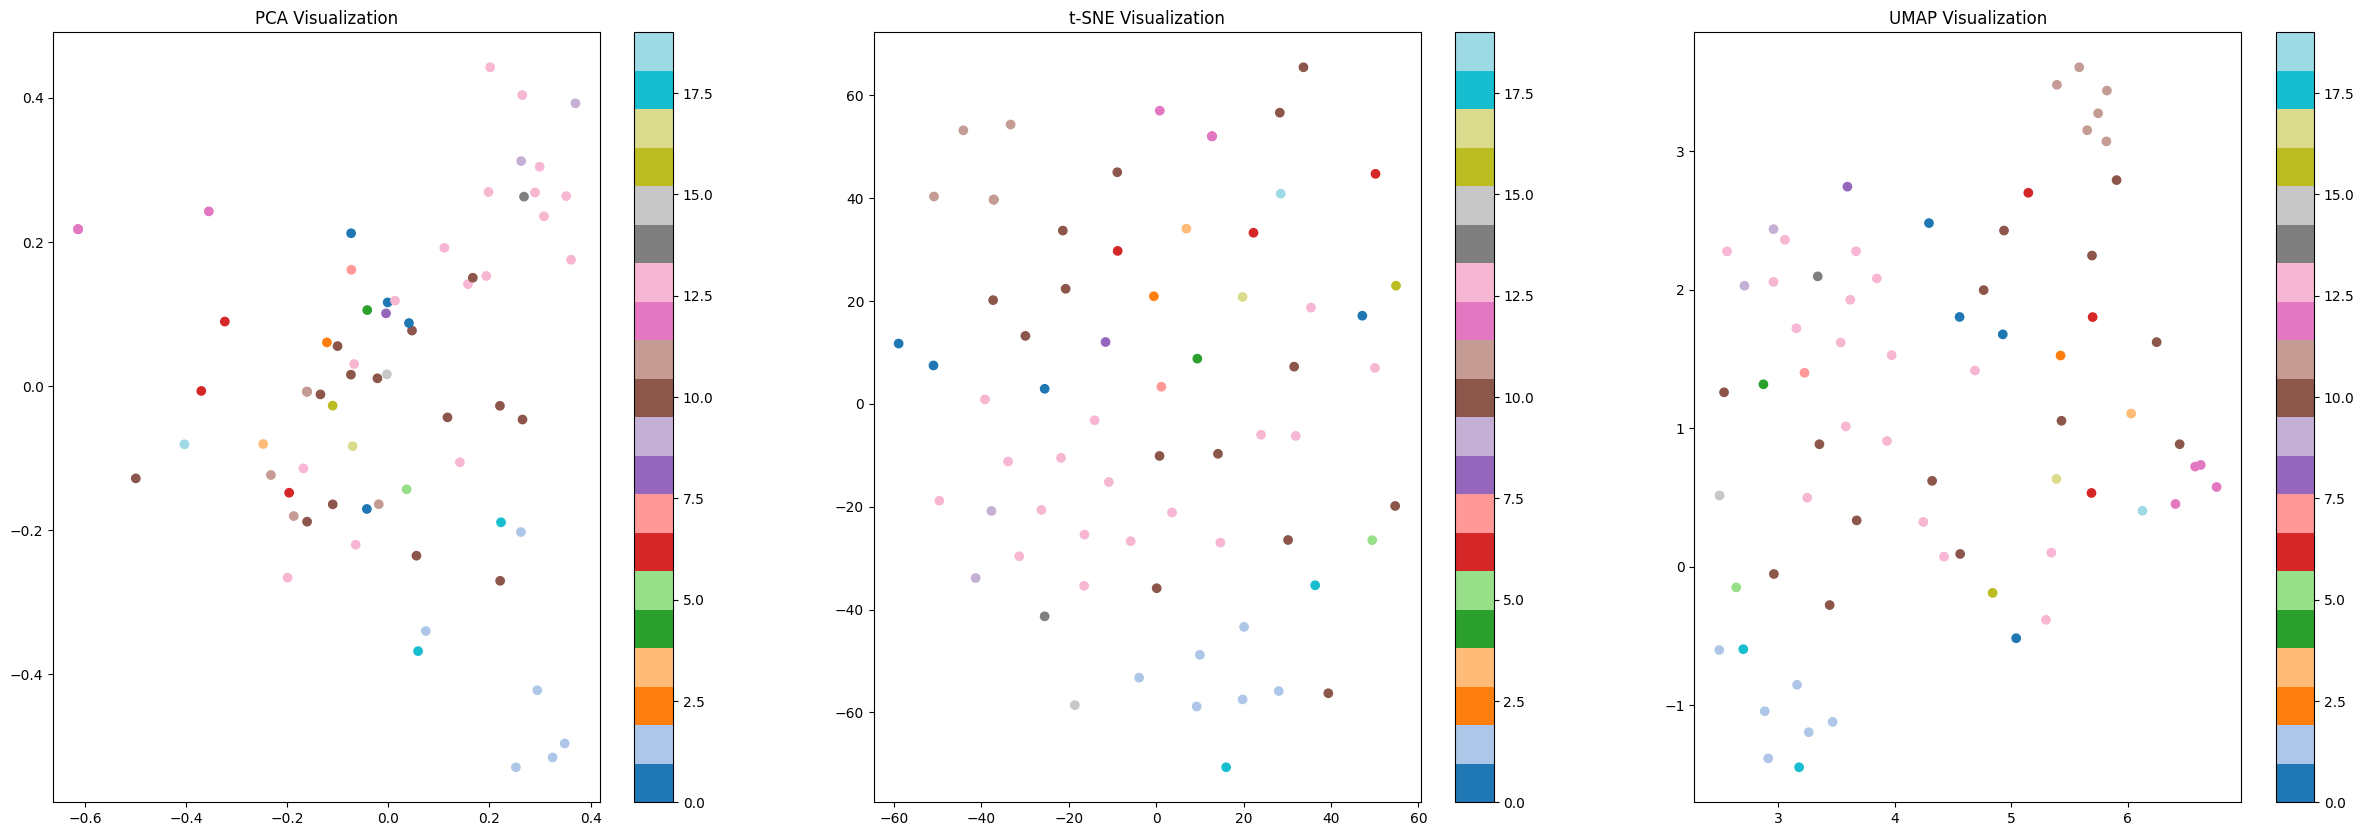

Clustering and dimensionality reduction results saved.


In [37]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt

b_pca_kmeans = True
b_update_kmeans_centers = True

if b_pca_kmeans:
    keyword = 'zombie'
    
    # Load existing K-means centers if available
    if os.path.isfile(s_root + s_kmeans_centers):
        with open(s_root + s_kmeans_centers, 'r') as f:
            d_kmeans_centers = json.load(f)
    else:
        d_kmeans_centers = {}

    # Load the DataFrame with embeddings
    df_total = pd.read_json(s_root + s_db_table_json, orient='records')
    df_total = df_total[df_total['embedding'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    
    # Convert embeddings to matrix
    mat = np.array(df_total['embedding'].tolist())

    # Embed the keyword and compute similarity for each entry
    keyword_embed = index_embedding(keyword)
    df_total['similarity'] = mat @ keyword_embed  # Dot product for cosine similarity

    # Define number of clusters for main clustering and sub-clustering
    n_clusters = 20
    n_clusters_sub = 2
    s_key = str(n_clusters)
    
    # Initialize K-means clusters or use precomputed centers
    if s_key in d_kmeans_centers:
        mat_init = np.array(d_kmeans_centers[s_key])
    else:
        mat_init = np.zeros((n_clusters, mat.shape[1]))
        np.fill_diagonal(mat_init, 1.0)
    
    # Main K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init=mat_init, n_init=1).fit(mat)
    df_total['kmeans'] = kmeans.labels_
    
    if b_update_kmeans_centers:
        d_kmeans_centers[s_key] = kmeans.cluster_centers_.tolist()

    # Sub-clustering for larger clusters
    df_total['kmeans_sub'] = 0
    for i_c in range(n_clusters):
        cluster_indices = np.where(df_total['kmeans'] == i_c)[0]
        if len(cluster_indices) > len(df_total) / n_clusters:
            mat_i_c = mat[cluster_indices, :]
            s_key_sub = f"{n_clusters}_{i_c}_{n_clusters_sub}"
    
            # Adjust n_clusters_sub if fewer samples than sub-clusters
            adjusted_n_clusters_sub = min(n_clusters_sub, len(mat_i_c))
    
            if s_key_sub in d_kmeans_centers and adjusted_n_clusters_sub == n_clusters_sub:
                mat_init_sub = np.array(d_kmeans_centers[s_key_sub])
            else:
                mat_init_sub = np.zeros((adjusted_n_clusters_sub, mat.shape[1]))
                np.fill_diagonal(mat_init_sub, 1.0)
    
            # Apply KMeans with adjusted number of clusters
            kmeans_sub = KMeans(n_clusters=adjusted_n_clusters_sub, init=mat_init_sub, n_init=1).fit(mat_i_c)
            df_total.loc[cluster_indices, 'kmeans_sub'] = kmeans_sub.labels_
    
            if b_update_kmeans_centers and adjusted_n_clusters_sub == n_clusters_sub:
                d_kmeans_centers[s_key_sub] = kmeans_sub.cluster_centers_.tolist()


    # Dimensionality Reduction Techniques
    methods = [
        ('PCA', PCA(n_components=3)),
        ('t-SNE', TSNE(n_components=2)),
        ('UMAP', UMAP(n_components=2))
    ]

    # Visualization
    plt.figure(figsize=(30, 10))
    for i, (name, model) in enumerate(methods):
        print(name)
        plt.subplot(1, 3, i + 1)

        if name == 'PCA':
            X_embedded = model.fit_transform(mat)
            df_total['first_dim_PCA'] = X_embedded[:, 0]
            df_total['second_dim_PCA'] = X_embedded[:, 1]
            df_total['third_dim_PCA'] = X_embedded[:, 2]
            plt.scatter(X_embedded[:, 1], X_embedded[:, 2], c=df_total['kmeans'], cmap='tab20')
        else:
            X_embedded = model.fit_transform(mat)
            df_total[f'first_dim_{name}'] = X_embedded[:, 0]
            df_total[f'second_dim_{name}'] = X_embedded[:, 1]
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_total['kmeans'], cmap='tab20')

        plt.title(f"{name} Visualization")
        plt.colorbar()

    plt.show()

    # Save K-means centers and DataFrame with clustering results
    with open(s_root + s_kmeans_centers, 'w') as f:
        json.dump(d_kmeans_centers, f)

    df_total.to_json(s_root + s_db_table_pca_json, orient='records')
    df_total.to_excel(s_root + s_db_table_pca_xlsx, index=False)
    print("Clustering and dimensionality reduction results saved.")
